## GAN

In [3]:
!pip install tensorflow

Loading and preprocessing dataset...
Initializing and training Enhanced WGAN-GP...

Epoch 0
D Loss: -1.1033, G Loss: 3.8920
R-squared: -0.0652
Wasserstein Distance: 0.4617

Epoch 50
D Loss: -1.1005, G Loss: -1.1199
R-squared: 0.0419
Wasserstein Distance: 0.4230

Epoch 100
D Loss: -0.7191, G Loss: -1.6313
R-squared: 0.1099
Wasserstein Distance: 0.3931

Epoch 150
D Loss: -0.5367, G Loss: -1.2635
R-squared: 0.1056
Wasserstein Distance: 0.3936

Epoch 200
D Loss: -0.5149, G Loss: -0.7752
R-squared: 0.1680
Wasserstein Distance: 0.3702

Epoch 250
D Loss: -0.3921, G Loss: -0.3984
R-squared: 0.1438
Wasserstein Distance: 0.3778

Epoch 300
D Loss: -0.3159, G Loss: -0.5888
R-squared: 0.1768
Wasserstein Distance: 0.3640

Epoch 350
D Loss: -0.2426, G Loss: -0.4351
R-squared: 0.1226
Wasserstein Distance: 0.3792


Generating synthetic data...

Evaluating metrics...
MSE: 0.4424
R-squared: 0.0514
Wasserstein Distance: 0.3993
Silhouette Score (Real): 0.2597
Silhouette Score (Synthetic): 0.2873
Calinski-H

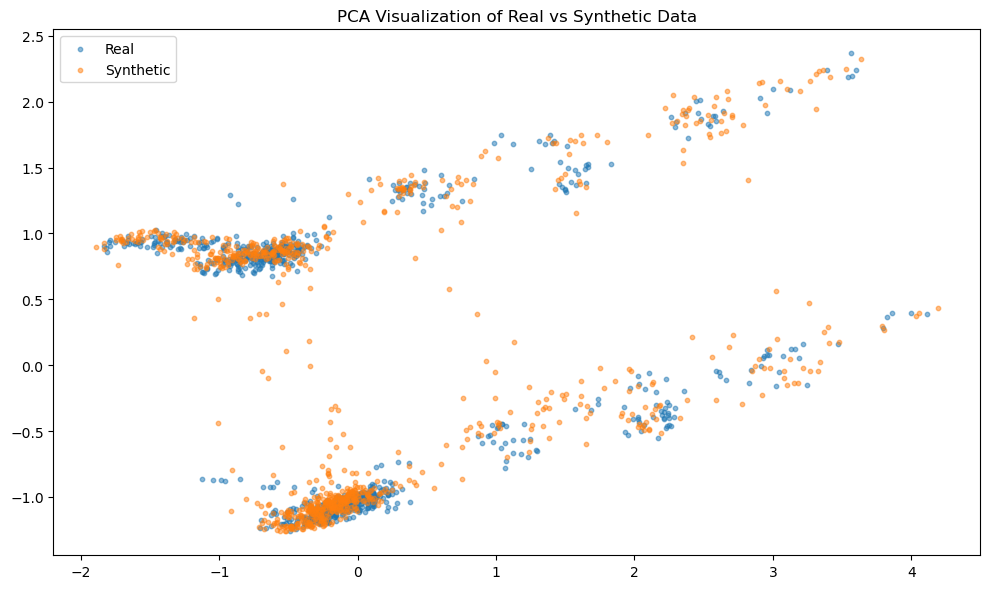

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

class ResidualBlock(layers.Layer):
    def __init__(self, units, dropout_rate=0.3):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)

        self.dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)

        self.residual = layers.Dense(units)

    def call(self, x, training=False):
        residual = self.residual(x)

        x = self.dense1(x)
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)

        x = self.dense2(x)
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)

        return x + residual

class EnhancedWGAN_GP:
    def __init__(self, input_dim, latent_dim=256, lambda_gp=10):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 5
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        # Learning rate scheduling
        self.g_lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000,
            decay_rate=0.95
        )
        self.d_lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000,
            decay_rate=0.95
        )

        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.9
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.9
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))

        x = layers.Dense(512)(noise_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        # Residual blocks
        x = ResidualBlock(1024)(x)
        x = ResidualBlock(2048)(x)
        x = ResidualBlock(4096)(x)

        # Additional processing
        x = layers.Dense(2048)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        # Output layer with skip connection
        direct_mapping = layers.Dense(self.input_dim)(noise_input)
        main_output = layers.Dense(self.input_dim)(x)
        output = layers.Add()([direct_mapping, main_output])
        output = layers.Activation('tanh')(output)

        return models.Model(noise_input, output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))

        x = layers.Dense(2048)(data_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        # Residual blocks
        x = ResidualBlock(1024, dropout_rate=0.3)(x)
        x = ResidualBlock(512, dropout_rate=0.3)(x)
        x = ResidualBlock(256, dropout_rate=0.3)(x)

        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        output = layers.Dense(1)(x)

        return models.Model(data_input, output)

    def gradient_penalty(self, real_samples, fake_samples):
        real_samples = tf.cast(real_samples, tf.float32)
        fake_samples = tf.cast(fake_samples, tf.float32)

        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0, dtype=tf.float32)

        interpolated = alpha * real_samples + (1 - alpha) * fake_samples

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            interpolated_predictions = self.discriminator(interpolated, training=True)

        gradients = tape.gradient(interpolated_predictions, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gradient_penalty

    @tf.function
    def train_step(self, real_samples, batch_size):
        real_samples = tf.cast(real_samples, tf.float32)

        # Train discriminator
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim), dtype=tf.float32)
            with tf.GradientTape() as tape:
                fake_samples = self.generator(noise, training=True)
                real_output = self.discriminator(real_samples, training=True)
                fake_output = self.discriminator(fake_samples, training=True)

                gp = self.gradient_penalty(real_samples, fake_samples)
                d_loss = (tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) +
                         self.lambda_gp * gp)

            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train generator
        noise = tf.random.normal((batch_size, self.latent_dim), dtype=tf.float32)
        with tf.GradientTape() as tape:
            fake_samples = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_samples, training=True)
            g_loss = -tf.reduce_mean(fake_output)

        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return d_loss, g_loss

    def train(self, data, epochs=200, batch_size=64, early_stopping_patience=50):
        data = tf.cast(data, tf.float32)
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size)

        best_wasserstein = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            d_losses = []
            g_losses = []

            for batch in dataset:
                d_loss, g_loss = self.train_step(batch, tf.shape(batch)[0])
                d_losses.append(d_loss)
                g_losses.append(g_loss)

            if epoch % 50 == 0:
                # Generate samples for evaluation
                test_samples = self.generate(1000)
                metrics = evaluate_metrics(data[:1000].numpy(), test_samples, verbose=False)
                current_wasserstein = metrics['Wasserstein Distance']

                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}, G Loss: {tf.reduce_mean(g_losses):.4f}")
                print(f"R-squared: {metrics['R-squared']:.4f}")
                print(f"Wasserstein Distance: {current_wasserstein:.4f}\n")

                if current_wasserstein < best_wasserstein:
                    best_wasserstein = current_wasserstein
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    def generate(self, num_samples):
        noise = tf.random.normal((num_samples, self.latent_dim), dtype=tf.float32)
        return self.generator(noise, training=False).numpy()

def load_and_preprocess_data(dataset_path=r"D:\apass9_cleaned.csv"):
    df = pd.read_csv(dataset_path).dropna()

    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)

    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    if synthetic_data.shape[0] > real_data.shape[0]:
        synthetic_data = synthetic_data[:real_data.shape[0]]

    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data)),
    }

    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)

        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except ValueError as e:
        print(f"Clustering Error: {e}")

    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return metrics

def plot_distributions(real_data, synthetic_data):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization of Real vs Synthetic Data")
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing dataset...")
    original_data, scalers = load_and_preprocess_data()

    print("Initializing and training Enhanced WGAN-GP...")
    gan_model = EnhancedWGAN_GP(
        input_dim=original_data.shape[1],
        latent_dim=256,
        lambda_gp=10
    )

    gan_model.train(
        original_data,
        epochs=400,
        batch_size=64,
        early_stopping_patience=50
    )

    print("\nGenerating synthetic data...")
    synthetic_data = gan_model.generate(num_samples=original_data.shape[0])

    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)

    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)

if __name__ == "__main__":
    main()

## CONDITIONAL ADVERSARIAL NETWORKS- CGAN

Loading data...
Preprocessing...
Creating conditions using clustering...
Initializing CGAN...

Training CGAN...
Epoch 0
D Loss: -1.9221
G Loss: 1.1208

Epoch 10
D Loss: -2.2984
G Loss: 0.0175

Epoch 20
D Loss: -2.0821
G Loss: 1.5205

Epoch 30
D Loss: -1.7917
G Loss: 1.3432

Epoch 40
D Loss: -1.4755
G Loss: 1.1772

Epoch 50
D Loss: -1.2175
G Loss: 0.9545

Epoch 60
D Loss: -1.1601
G Loss: 0.5528

Epoch 70
D Loss: -1.1569
G Loss: 0.6176

Epoch 80
D Loss: -1.1910
G Loss: 0.0791

Epoch 90
D Loss: -0.9476
G Loss: 0.4546

Epoch 100
D Loss: -0.8074
G Loss: 0.2209

Epoch 110
D Loss: -0.7032
G Loss: 0.4035

Epoch 120
D Loss: -0.5613
G Loss: 0.1323

Epoch 130
D Loss: -0.4084
G Loss: -0.3890

Epoch 140
D Loss: -0.3290
G Loss: -0.4077

Epoch 150
D Loss: -0.3115
G Loss: -0.5628

Epoch 160
D Loss: -0.2390
G Loss: -0.6601

Epoch 170
D Loss: -0.2359
G Loss: -0.5635

Epoch 180
D Loss: -0.2041
G Loss: -0.5775

Epoch 190
D Loss: -0.1873
G Loss: -0.5438

Epoch 200
D Loss: -0.1952
G Loss: -0.5927

Epoch 210

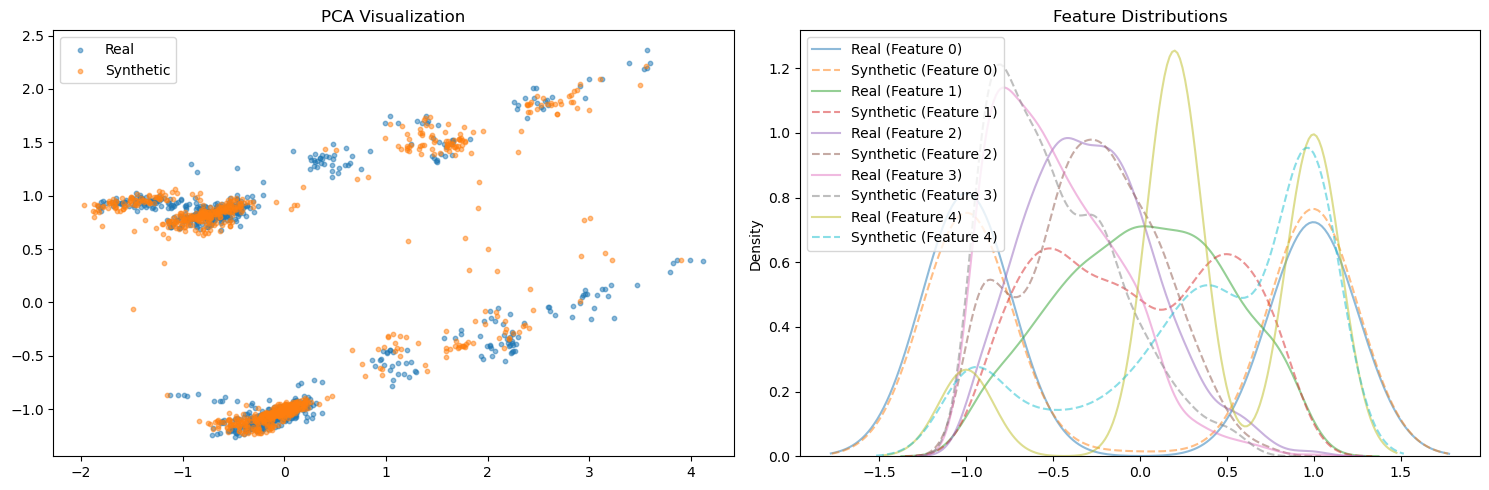


Saving results...

Training complete!
Synthetic data shape: (837, 24)
Original data shape: (837, 24)

Script completed successfully!


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

class ConditionalResidualBlock(layers.Layer):
    def __init__(self, units, condition_dim, dropout_rate=0.3):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.condition_dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)

        self.dense2 = layers.Dense(units)
        self.condition_dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)

        self.residual = layers.Dense(units)
        self.condition_residual = layers.Dense(units)

    def call(self, inputs, training=False):
        x, condition = inputs
        
        # Process condition
        condition1 = self.condition_dense1(condition)
        condition2 = self.condition_dense2(condition)
        condition_res = self.condition_residual(condition)
        
        # Main path
        residual = self.residual(x) + condition_res
        
        x = self.dense1(x) + condition1
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x) + condition2
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

class EnhancedCWGAN_GP:
    def __init__(self, input_dim, condition_dim, latent_dim=256, lambda_gp=10):
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 5
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        
        # Advanced learning rate scheduling
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9
        )
        
        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-5,
            beta_1=0.5,
            beta_2=0.9
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-5,
            beta_1=0.5,
            beta_2=0.9
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([noise_input, condition_input])
        
        x = layers.Dense(512)(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ConditionalResidualBlock(1024, self.condition_dim)([x, condition_input])
        x = ConditionalResidualBlock(2048, self.condition_dim)([x, condition_input])
        x = ConditionalResidualBlock(4096, self.condition_dim)([x, condition_input])
        
        x = layers.Dense(2048)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        direct_mapping = layers.Dense(self.input_dim)(combined_input)
        main_output = layers.Dense(self.input_dim)(x)
        output = layers.Add()([direct_mapping, main_output])
        output = layers.Activation('tanh')(output)
        
        return models.Model([noise_input, condition_input], output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([data_input, condition_input])
        
        x = layers.Dense(2048)(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ConditionalResidualBlock(1024, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ConditionalResidualBlock(512, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ConditionalResidualBlock(256, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        
        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        output = layers.Dense(1)(x)
        
        return models.Model([data_input, condition_input], output)

    def gradient_penalty(self, real_samples, fake_samples, conditions):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0)
        
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            interpolated_predictions = self.discriminator([interpolated, conditions], training=True)
        
        gradients = tape.gradient(interpolated_predictions, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gradient_penalty

    @tf.function
    def train_step(self, real_samples, conditions, batch_size):
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            
            with tf.GradientTape() as tape:
                fake_samples = self.generator([noise, conditions], training=True)
                real_output = self.discriminator([real_samples, conditions], training=True)
                fake_output = self.discriminator([fake_samples, conditions], training=True)
                
                gp = self.gradient_penalty(real_samples, fake_samples, conditions)
                d_loss = (tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) +
                         self.lambda_gp * gp)
            
            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator([noise, conditions], training=True)
            fake_output = self.discriminator([fake_samples, conditions], training=True)
            g_loss = -tf.reduce_mean(fake_output)
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, conditions, epochs=200, batch_size=64, early_stopping_patience=50):
        dataset = tf.data.Dataset.from_tensor_slices((data, conditions))
        dataset = dataset.shuffle(10000).batch(batch_size)
        
        best_wasserstein = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch_data, batch_conditions in dataset:
                d_loss, g_loss = self.train_step(
                    batch_data, 
                    batch_conditions,
                    tf.shape(batch_data)[0]
                )
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}")
                print(f"G Loss: {tf.reduce_mean(g_losses):.4f}\n")
                
                current_wasserstein = tf.reduce_mean(d_losses)
                if current_wasserstein < best_wasserstein:
                    best_wasserstein = current_wasserstein
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    def generate(self, conditions, num_samples=None):
        if num_samples is None:
            num_samples = conditions.shape[0]
        
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator([noise, conditions], training=False)

def load_and_preprocess_data(dataset_path):
    print("Loading data...")
    df = pd.read_csv(dataset_path).dropna()
    
    print("Preprocessing...")
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)
    
    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data))
    }
    
    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)
        
        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except Exception as e:
        print(f"Clustering metrics calculation error: {e}")
    
    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return metrics

def plot_distributions(real_data, synthetic_data):
    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)
    
    plt.figure(figsize=(15, 5))
    
    # PCA scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization")
    
    # Density plot
    plt.subplot(1, 2, 2)
    for i in range(min(5, real_data.shape[1])):
        sns.kdeplot(data=real_data[:, i], label=f'Real (Feature {i})', alpha=0.5)
        sns.kdeplot(data=synthetic_data[:, i], label=f'Synthetic (Feature {i})', alpha=0.5, linestyle='--')
    plt.title("Feature Distributions")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    data_path = r"D:\apass9_cleaned.csv"  # Replace with your data path
    original_data, scalers = load_and_preprocess_data(data_path)
    
    # Create conditions using clustering
    print("Creating conditions using clustering...")
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(original_data)
    conditions = tf.one_hot(cluster_labels, depth=n_clusters)
    
    # Initialize and train the model
    print("Initializing CGAN...")
    cgan_model = EnhancedCWGAN_GP(
        input_dim=original_data.shape[1],
        condition_dim=conditions.shape[1],
        latent_dim=256,
        lambda_gp=10
    )
    
    print("Training CGAN...")
    cgan_model.train(
        original_data,
        conditions,
        epochs=400,
        batch_size=64,
        early_stopping_patience=50
    )
    
    # Generate and evaluate synthetic data
    print("Generating synthetic data...")
    synthetic_data = cgan_model.generate(conditions).numpy()
    
    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)
    
    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)
    
    # Save the results
    print("\nSaving results...")
    np.save('synthetic_data.npy', synthetic_data)
    
    # Print final summary
    print("\nTraining complete!")
    print("Synthetic data shape:", synthetic_data.shape)
    print("Original data shape:", original_data.shape)
    
    return cgan_model, synthetic_data, metrics

if __name__ == "__main__":
    # Enable memory growth for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    try:
        model, synthetic_data, metrics = main()
        print("\nScript completed successfully!")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")

## Contrastive Adversarial Networks - ContraGAN

Loading data...
Preprocessing...
Creating conditions using clustering...
Initializing ContraGAN...

Training ContraGAN...
Epoch 0
D Loss: -1.5018
G Loss: 1.9714

Epoch 10
D Loss: -2.5068
G Loss: 0.1023

Epoch 20
D Loss: -2.2265
G Loss: 0.4985

Epoch 30
D Loss: -1.2125
G Loss: 2.6966

Epoch 40
D Loss: -0.8538
G Loss: 2.9937

Epoch 50
D Loss: -0.7968
G Loss: 3.9534

Epoch 60
D Loss: -0.7769
G Loss: 4.1260

Epoch 70
D Loss: -0.7288
G Loss: 4.3281

Epoch 80
D Loss: -0.7904
G Loss: 4.5154

Epoch 90
D Loss: -0.6161
G Loss: 4.4522

Epoch 100
D Loss: -0.4976
G Loss: 4.4106

Epoch 110
D Loss: -0.4345
G Loss: 5.1048

Epoch 120
D Loss: -0.3864
G Loss: 4.8153

Epoch 130
D Loss: -0.3530
G Loss: 4.3079

Epoch 140
D Loss: -0.3142
G Loss: 4.6957

Epoch 150
D Loss: -0.2587
G Loss: 4.7869

Epoch 160
D Loss: -0.1168
G Loss: 3.9384

Epoch 170
D Loss: -0.1752
G Loss: 3.5185

Epoch 180
D Loss: 0.1377
G Loss: 3.7047

Epoch 190
D Loss: 0.2417
G Loss: 3.6502

Epoch 200
D Loss: -0.1444
G Loss: 3.3514

Epoch 210

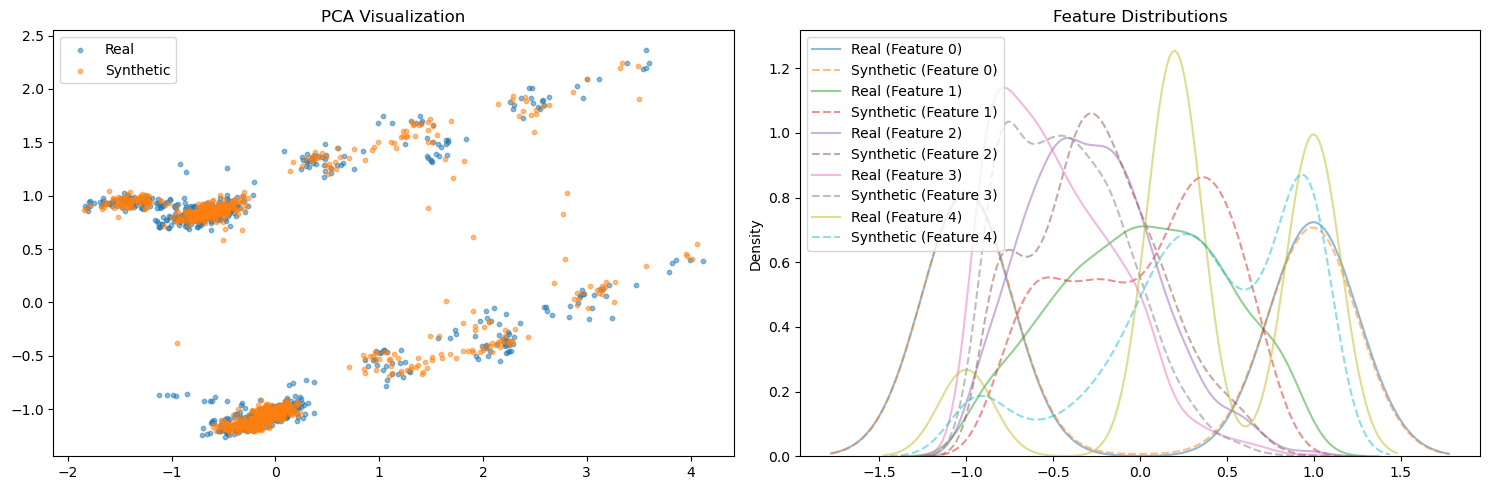


Saving results...

Training complete!
Synthetic data shape: (837, 24)
Original data shape: (837, 24)

Script completed successfully!


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

class ContrastiveResidualBlock(layers.Layer):
    def __init__(self, units, condition_dim, dropout_rate=0.3):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.condition_dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)
        
        self.dense2 = layers.Dense(units)
        self.condition_dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)
        
        self.residual = layers.Dense(units)
        self.condition_residual = layers.Dense(units)

    def call(self, inputs, training=False):
        x, condition = inputs
        
        condition1 = self.condition_dense1(condition)
        condition2 = self.condition_dense2(condition)
        condition_res = self.condition_residual(condition)
        
        residual = self.residual(x) + condition_res
        
        x = self.dense1(x) + condition1
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x) + condition2
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

class ContraGAN:
    def __init__(self, input_dim, condition_dim, latent_dim=256, lambda_gp=10, temperature=0.5):
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.temperature = temperature
        self.n_critic = 5
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.projector = self._build_projector()
        
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=1e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9,
            alpha=1e-5
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=1e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9,
            alpha=1e-5
        )
        
        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.999,
            clipnorm=1.0
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.999,
            clipnorm=1.0
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([noise_input, condition_input])
        
        x = layers.Dense(512, kernel_initializer='he_normal')(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ContrastiveResidualBlock(1024, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(2048, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(4096, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(2048, self.condition_dim)([x, condition_input])
        
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        direct_mapping = layers.Dense(self.input_dim)(combined_input)
        main_output = layers.Dense(self.input_dim)(x)
        output = layers.Add()([direct_mapping, main_output])
        output = layers.Activation('tanh')(output)
        
        return models.Model([noise_input, condition_input], output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([data_input, condition_input])
        
        x = layers.Dense(2048)(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ContrastiveResidualBlock(1024, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ContrastiveResidualBlock(512, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ContrastiveResidualBlock(256, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        
        features = layers.Dense(128)(x)
        features = layers.LeakyReLU(0.2)(features)
        features = layers.LayerNormalization()(features)
        
        validity = layers.Dense(1)(features)
        
        return models.Model([data_input, condition_input], [validity, features])

    def _build_projector(self):
        feature_input = layers.Input(shape=(128,))
        
        x = layers.Dense(256)(feature_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = layers.Dense(128)(x)
        x = layers.LayerNormalization()(x)
        
        return models.Model(feature_input, x)

    def contrastive_loss(self, features_real, features_fake):
        features_real = tf.nn.l2_normalize(features_real, axis=1)
        features_fake = tf.nn.l2_normalize(features_fake, axis=1)
        
        similarity_matrix = tf.matmul(features_real, features_fake, transpose_b=True)
        similarity_matrix = similarity_matrix / self.temperature
        
        labels = tf.eye(tf.shape(features_real)[0])
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=similarity_matrix))
        
        return loss

    def gradient_penalty(self, real_samples, fake_samples, conditions):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0)
        
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            validity, _ = self.discriminator([interpolated, conditions], training=True)
        
        gradients = tape.gradient(validity, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gradient_penalty

    @tf.function
    def train_step(self, real_samples, conditions, batch_size):
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            
            with tf.GradientTape() as tape:
                fake_samples = self.generator([noise, conditions], training=True)
                
                real_validity, real_features = self.discriminator([real_samples, conditions], training=True)
                fake_validity, fake_features = self.discriminator([fake_samples, conditions], training=True)
                
                real_proj = self.projector(real_features, training=True)
                fake_proj = self.projector(fake_features, training=True)
                
                gp = self.gradient_penalty(real_samples, fake_samples, conditions)
                wasserstein_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity)
                contrastive_d_loss = self.contrastive_loss(real_proj, fake_proj)
                
                d_loss = wasserstein_loss + self.lambda_gp * gp + 0.1 * contrastive_d_loss
            
            d_gradients = tape.gradient(d_loss, 
                self.discriminator.trainable_variables + self.projector.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradients, 
                    self.discriminator.trainable_variables + self.projector.trainable_variables))
        
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator([noise, conditions], training=True)
            
            fake_validity, fake_features = self.discriminator([fake_samples, conditions], training=True)
            real_validity, real_features = self.discriminator([real_samples, conditions], training=True)
            
            real_proj = self.projector(real_features, training=True)
            fake_proj = self.projector(fake_features, training=True)
            
            wasserstein_loss = -tf.reduce_mean(fake_validity)
            contrastive_g_loss = self.contrastive_loss(fake_proj, real_proj)
            
            g_loss = wasserstein_loss + 0.1 * contrastive_g_loss
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, conditions, epochs=200, batch_size=64, early_stopping_patience=50):
        dataset = tf.data.Dataset.from_tensor_slices((data, conditions))
        dataset = dataset.shuffle(10000).batch(batch_size)
        
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch_data, batch_conditions in dataset:
                d_loss, g_loss = self.train_step(
                    batch_data, 
                    batch_conditions,
                    tf.shape(batch_data)[0]
                )
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                d_loss_mean = tf.reduce_mean(d_losses)
                g_loss_mean = tf.reduce_mean(g_losses)
                print(f"Epoch {epoch}")
                print(f"D Loss: {d_loss_mean:.4f}")
                print(f"G Loss: {g_loss_mean:.4f}\n")
                
                current_loss = d_loss_mean + g_loss_mean
                if current_loss < best_loss:
                    best_loss = current_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    def generate(self, conditions, num_samples=None):
        if num_samples is None:
            num_samples = conditions.shape[0]
        
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator([noise, conditions], training=False)

def load_and_preprocess_data(dataset_path):
    print("Loading data...")
    df = pd.read_csv(dataset_path).dropna()
    
    print("Preprocessing...")
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)
    
    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data))
    }
    
    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)
        
        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except Exception as e:
        print(f"Clustering metrics calculation error: {e}")
    
    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return metrics

def plot_distributions(real_data, synthetic_data):
    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)
    
    plt.figure(figsize=(15, 5))
    
    # PCA scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization")
    
    # Density plot
    plt.subplot(1, 2, 2)
    for i in range(min(5, real_data.shape[1])):
        sns.kdeplot(data=real_data[:, i], label=f'Real (Feature {i})', alpha=0.5)
        sns.kdeplot(data=synthetic_data[:, i], label=f'Synthetic (Feature {i})', alpha=0.5, linestyle='--')
    plt.title("Feature Distributions")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    data_path = r"D:\apass9_cleaned.csv"  
    original_data, scalers = load_and_preprocess_data(data_path)
    
    # Create conditions using clustering
    print("Creating conditions using clustering...")
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(original_data)
    conditions = tf.one_hot(cluster_labels, depth=n_clusters)
    
    # Initialize and train the model
    print("Initializing ContraGAN...")
    cgan_model = ContraGAN(
        input_dim=original_data.shape[1],
        condition_dim=conditions.shape[1],
        latent_dim=256,
        lambda_gp=10
    )
    
    print("Training ContraGAN...")
    cgan_model.train(
        original_data,
        conditions,
        epochs=400,
        batch_size=64,
        early_stopping_patience=50
    )
    
    # Generate and evaluate synthetic data
    print("Generating synthetic data...")
    synthetic_data = cgan_model.generate(conditions).numpy()
    
    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)
    
    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)
    
    # Save the results
    print("\nSaving results...")
    np.save('synthetic_data.npy', synthetic_data)
    
    # Print final summary
    print("\nTraining complete!")
    print("Synthetic data shape:", synthetic_data.shape)
    print("Original data shape:", original_data.shape)
    
    return cgan_model, synthetic_data, metrics

if __name__ == "__main__":
    # Enable memory growth for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    try:
        model, synthetic_data, metrics = main()
        print("\nScript completed successfully!")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
